# Import Libraries

In [39]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from symspellpy import SymSpell
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Read Dataset

In [40]:
df = pd.read_excel("Product Matching Dataset.xlsx" , sheet_name="Dataset")
# df.head(n=10)

# Preprocessing

In [3]:
# stop_words = set(stopwords.words("arabic")) | set(stopwords.words("english"))

# # text_column = df["seller_item_name"].astype(str)  # Ensure text format

In [42]:
from qalsadi.lemmatizer import Lemmatizer

# Initialize the Arabic lemmatizer
lemmatizer = Lemmatizer()

def preprocessing(text):
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove Arabic diacritics (tashkeel)
    text = re.sub(r"[\u064B-\u065F]", "", text)
    
    # Remove non-Arabic characters except numbers
    text = re.sub(r'[^\u0621-\u064A0-9\s]', ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Standardize specific terms
    text = re.sub(r'قرص|\bق\b|\bك\b|اقراص|كبسوله', 'كبسول', text)
    text = re.sub(r'([\u0600-\u06FF])\1+', r'\1', text)  # Remove Arabic repetition
    text = re.sub(r'[إأآ]', 'ا', text)
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ة', 'ه ', text)
    text = re.sub(r'ؤ', 'و', text)
    text = re.sub(r'ئ', 'ي', text)
    
    # Separate numbers that stick to Arabic/English words
    text = re.sub(r"(\d+)([a-zA-Z\u0600-\u06FF]+)", r"\1 \2", text)  # Number followed by Arabic/English
    text = re.sub(r"([a-zA-Z\u0600-\u06FF]+)(\d+)", r"\1 \2", text)  # Arabic/English followed by number
    
    # Remove standalone Arabic/English characters (but not numbers)
    text = re.sub(r"\b[^\W\d]\b", "", text)
    
    # Remove specific unwanted phrases
    text = re.sub(r'\b(?:سعر جديد|سعر|قديم|س جديد|س جدي|س ج|ركز)\b', '', text)
    text = re.sub(r'مرهم|اكريم', 'كريم', text)
    text = re.sub(r'مليجرام|\bم\b|مجم', 'مجم', text)
    text = re.sub(r'جرام|جم', 'جم', text)
    text = re.sub(r'شرائط|شريطين', 'شريط', text)
    text = re.sub(r'امبولات|امبوله|حقن', 'امبول', text)
    text = re.sub(r'لبوس|لبوس اطفال', 'اقماع', text)
    
    # Remove multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenize the text
    tokens = text.split()
    
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the lemmatized tokens back into a single string
    lemmatized_text = " ".join(lemmatized_tokens)
    
    return lemmatized_text

In [43]:
df["cleaned_seller_item_name"] = df["seller_item_name"].astype(str).apply(preprocessing)

c:\Python312\Lib\site-packages\qalsadi\analex.py:109: SyntaxWarning: invalid escape sequence '\w'
  "([\w%s\s]+)" % (u"".join(araby.TASHKEEL), ), re.UNICODE)


KeyboardInterrupt: 

In [ ]:
# Scale Price
scaler = StandardScaler()
df["scaled_price"] = scaler.fit_transform(df[["price"]])

<Axes: ylabel='Frequency'>

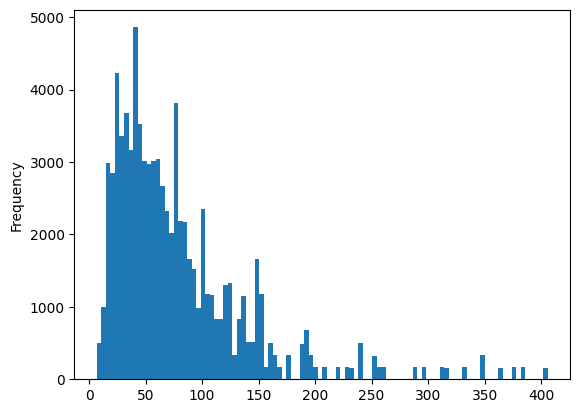

In [ ]:
# plot the distribution of price column
df["price"].plot.hist(bins=100)

<Axes: >

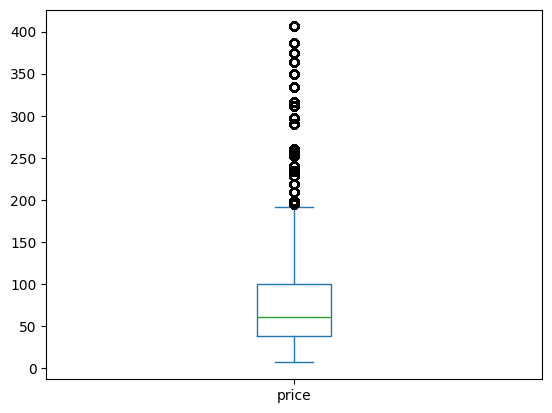

In [31]:
# Remove outliers
df = df[df["price"] < 1000]
# plot boxplot to check for outliers
df["price"].plot.box()

In [33]:
df.duplicated().sum()

33990

In [34]:
# drop duplicates
df_2 = df.drop_duplicates(keep="first")

#### Splitting Data

In [38]:
# Feature and Target
X = df[["cleaned_seller_item_name", "scaled_price"]]
Y = df["sku"]

# Label Encoding for SKU
label_encoder = LabelEncoder()
df["encoded_sku"] = label_encoder.fit_transform(Y)

KeyError: "['scaled_price'] not in index"

### Model Selection

In [ ]:
# Tokenization for RNN
num_words = 5000
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X["cleaned_seller_item_name"])
sequences = tokenizer.texts_to_sequences(X["cleaned_seller_item_name"])

# Padding
max_length = max(len(seq) for seq in sequences)
x_padded = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")

# Train-Test Split for RNN
X_train, X_test, y_train, y_test = train_test_split(x_padded, df["encoded_sku"], test_size=0.2, random_state=42, stratify=df["encoded_sku"], shuffle=True)

# Build Improved RNN Model
rnn_model = Sequential([
    Embedding(input_dim=num_words, output_dim=256, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(GRU(32)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(len(label_encoder.classes_), activation="softmax")
])

rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])

# Early Stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train RNN Model
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate RNN Model
loss, accuracy = rnn_model.evaluate(X_test, y_test)
print(f"RNN Model Accuracy: {accuracy:.4f}")

C:\Users\hassa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 67s 29ms/step - accuracy: 0.1191 - loss: 4.7483 - val_accuracy: 0.8717 - val_loss: 1.0730
Epoch 2/100
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - accuracy: 0.8630 - loss: 0.9335 - val_accuracy: 0.9743 - val_loss: 0.2818
Epoch 3/100
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.9615 - loss: 0.3295 - val_accuracy: 0.9793 - val_loss: 0.1942
Epoch 4/100
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.9747 - loss: 0.2020 - val_accuracy: 0.9793 - val_loss: 0.1604
Epoch 5/100
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step - accuracy: 0.9785 - loss: 0.1450 - val_accuracy: 0.9800 - val_loss: 0.1511
Epoch 6/100
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.9793 - loss: 0.1231 - val_accuracy: 0.9807 - val_loss: 0.1459
Epoch 7/100
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 51s 24ms/step - accuracy: 0.9817 - loss: 0.1055 - val_accuracy: 0.9804 - val_loss: 0.1487
Epoch 8/100
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 45s 22ms/step - accuracy: 

In [4]:
df["cleaned_seller_item_name"] = df["seller_item_name"].astype(str).apply(preprocessing)
scaler = StandardScaler()
df["scaled_price"] = scaler.fit_transform(df[["price"]])
X = df[["cleaned_seller_item_name", "scaled_price"]]
Y = df["sku"]




In [ ]:
# text  = preprocessing("تورسيرتيك5مجم")
# text  = preprocessing("تورسيرتيك 5مجم")
# text  = preprocessing("SPANIELA MR35MG30TAB")
# text  = preprocessing("شوجارلو بلس 1000/50مج30قرص س ج/الاسراء")
# text

'شوجارلو بلس 1000 50 مج 30 كبسول الاسراء'

# Build SymSpell Dictionary

In [13]:
# from symspellpy import SymSpell
# import pandas as pd

# # Load DataFrame
# df = pd.DataFrame({
#     "marketplace_product_name_ar": ["منتج", "منتج", "منتج جديد", "منج جديد"],  # Example Data
#     "cleaned_seller_item_name": ["منتج جد", "منتج جدي", "منتج جديي", "منج جد"]
# })

# # 1. Create Word Frequency Dictionary
# word_freq_dict = {}
# for product in df["marketplace_product_name_ar"].dropna():
#     normalized_product = str(product).strip()
#     word_freq_dict[normalized_product] = word_freq_dict.get(normalized_product, 0) + 1

# # Save Dictionary (Ensure tab separation)
# dict_file = "product_dictionary.txt"
# with open(dict_file, "w", encoding="utf-8") as f:
#     for word, freq in word_freq_dict.items():
#         f.write(f"{word}\t{freq}\n")  # Use TAB instead of SPACE

# # 2. Initialize SymSpell
# sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# # Load Dictionary and Check if Loaded Correctly
# if not sym_spell.load_dictionary(dict_file, term_index=0, count_index=1, encoding="utf-8"):
#     print("Dictionary loading failed!")

# # 3. Apply SymSpell Correction
# def correct_text(text):
#     suggestions = sym_spell.lookup(text, verbosity=0, max_edit_distance=2)  # Use verbosity=0 for best match
#     return suggestions[0].term if suggestions else text

# df["corrected_seller_item_name"] = df["cleaned_seller_item_name"].apply(correct_text)

# # Show Results
# print(df[["cleaned_seller_item_name", "corrected_seller_item_name"]])





ValueError: Column 'marketplace_product_name_ar' not found in dataset!

In [ ]:
# import pandas as pd

# dataset_filename = "Product Matching Dataset.xlsx"  # Your file name

# df = pd.read_excel(dataset_filename, sheet_name="Dataset")  # Load Excel file
# print(df.columns.tolist())  # Print all column names


['sku', 'marketplace_product_name_ar', 'seller_item_name', 'price']


# Train Models

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, df['encoded_sku'], test_size=0.2, random_state=42, stratify=df['encoded_sku'], shuffle=True)

vectorizer = TfidfVectorizer(max_features=500)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_tfidf, y_train)

y_pred = logistic_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

NameError: name 'X' is not defined

In [ ]:
# label_encoder = LabelEncoder()
# df["encoded_sku"] = label_encoder.fit_transform(df["sku"])

# # Tokenization for RNN
# num_words = 5000
# tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
# tokenizer.fit_on_texts(df["cleaned_seller_item_name"])
# sequences = tokenizer.texts_to_sequences(df["cleaned_seller_item_name"])

# # Padding
# max_length = max(len(seq) for seq in sequences)
# x_padded = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")

# # Train-Test Split for RNN
# X_train, X_test, y_train, y_test = train_test_split(x_padded, df["encoded_sku"], test_size=0.3, random_state=42)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.3, random_state=42)

# rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# # Early Stopping
# early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# # Train RNN Model
# rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# loss, accuracy = rnn_model.evaluate(X_test, y_test)
# print(f"RNN Model Accuracy: {accuracy:.4f}")


# Label Encoding for SKU
label_encoder = LabelEncoder()
df["encoded_sku"] = label_encoder.fit_transform(df["sku"])

# # Tokenization for RNN
# num_words = 5000
# tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
# tokenizer.fit_on_texts(X)
# sequences = tokenizer.texts_to_sequences(X)

# # Padding
# max_length = max(len(seq) for seq in sequences)
# x_padded = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")

# Train-Test Split for RNN
X_train, X_test, y_train, y_test = train_test_split(x_padded, df["encoded_sku"], test_size=0.3, random_state=42)

# Build Improved RNN Model
rnn_model = Sequential([
    Embedding(input_dim=num_words, output_dim=256, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(GRU(32)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(len(label_encoder.classes_), activation="softmax")
])

# rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])

# # Early Stopping
# early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# # Train RNN Model
# rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# loss, accuracy = rnn_model.evaluate(X_test, y_test)
# print(f"RNN Model Accuracy: {accuracy:.4f}")


Logistic Regression Model Accuracy: 0.8648


C:\Users\hassa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.1221 - loss: 4.7405 - val_accuracy: 0.8558 - val_loss: 1.0872
Epoch 2/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.8361 - loss: 0.9156 - val_accuracy: 0.9420 - val_loss: 0.2969
Epoch 3/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.9329 - loss: 0.3006 - val_accuracy: 0.9500 - val_loss: 0.2200
Epoch 4/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.9475 - loss: 0.1839 - val_accuracy: 0.9501 - val_loss: 0.2161
Epoch 5/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.9503 - loss: 0.1493 - val_accuracy: 0.9528 - val_loss: 0.2165
Epoch 6/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.9564 - loss: 0.1233 - val_accuracy: 0.9559 - val_loss: 0.2106
Epoch 7/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.9583 - loss: 0.1090 - val_accuracy: 0.9558 - val_loss: 0.2159
Epoch 8/100
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 

In [ ]:
def predict_sku(medicine_name, threshold=0.5):
    # Preprocess the input name
    cleaned_text = preprocessing(medicine_name)
    
    # Convert to sequence
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(seq, maxlen=max_length, padding="post", truncating="post")

    # Get model predictions
    predictions = rnn_model.predict(padded_seq)[0]
    
    # Get highest probability SKU
    max_prob = np.max(predictions)
    predicted_label = np.argmax(predictions)

    # If confidence is low, return "unknown"
    if max_prob < threshold:
        return "unknown"

    # Convert label back to SKU
    return label_encoder.inverse_transform([predicted_label])[0]

# # Example Predictions
# print(predict_sku("بانادول اكسترا"))  # Should return the correct SKU or "unknown"
# print(predict_sku("شوجارلو بلس 50/1000  30"))  # Should return "unknown"
# print(predict_sku("GLIPTUS PLUS 50/1000 MG 30 TAB"))  # Should return "unknown"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
116


In [15]:
probabilities = rnn_model.predict(X_test)

confidence_scores = np.max(probabilities, axis=1)

predicted_indices = np.argmax(probabilities, axis=1)

predicted_labels = label_encoder.inverse_transform(predicted_indices)

confidence_threshold = 0.85

test_results = []

for i in range(len(X_test)):
    confidence = confidence_scores[i]
    predicted_class = predicted_labels[i]

    if confidence < confidence_threshold:
        predicted_class = "Unknown"

    test_results.append({
        'Predicted': predicted_class,
        'Confidence': f"{confidence:.2f}"
    })

temp_df = pd.DataFrame(test_results)

temp_df.head()
df.to_csv("predict.csv" , index=False)


784/784 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [ ]:
# pip install farasa

   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
    --------------------------------------- 0.3/12.6 MB ? eta -:--:--
    --------------------------------------- 0.3/12.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.6 MB 645.7 kB/s eta 0:00:19
   - -------------------------------------- 0.5/12.6 MB 645.7 kB/s eta 0:00:19
   -- ------------------------------------- 0.8/12.6 MB 657.8 kB/s eta 0:00:18
   -- ------------------------------------- 0.8/12.6 MB 657.8 kB/s eta 0:00:18
   --- ------------------------------------ 1.0/12.6 MB 645.7 kB/s eta 0:00:18
   --- ------------------------------------ 1.0/12.6 MB 645.7 kB/s eta 0:00:18
   --- ------------------------------------ 1.0/12.6 MB 645.7 kB/s eta 0:00:18
   ---- ----------------------------------- 1.3/12.6 MB 583.5 kB/s eta 0:00:20
   ---- ----------------------------------- 1.3/12.6 MB 583.5 kB/s eta 0:00:20
   ---- -


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# from farasa.segmenter import FarasaSegmenter

# def correct_spelling_arabic(text):
#     segmenter = FarasaSegmenter()
#     corrected_text = segmenter.spellcheck(text)
#     return corrected_text

# # Test
# text = "فلكسوفان كيسول س ج ركزز"
# corrected_text = correct_spelling_arabic(text)
# print(corrected_text)  # Output: "فليكسوفان كبسول س ج ركزز"

ModuleNotFoundError: No module named 'farasa.segmenter'